# Architecture experiment: Subjective and physiological responses to interiors


### Libraries

- [scikit-learn](http://scikit-learn.org/stable/)
- [pandas](https://pandas.pydata.org/)
- matplotlib
- seaborn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import joblib #conda install -c anaconda joblib #For saving the sklearn models.
import imageio #conda install -c conda-forge imageio
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.decomposition import PCA
from sklearn import preprocessing
import seaborn as sns 
%matplotlib inline

In [2]:
DATA_FOLDER = './data/' #The data is in the .gitignore in order to not upload it to the GitHub repository
VIS_FOLDER = './visualizations/' #Folder where we save the visualizations
MODELS_FOLDER = './sklearn_models/' #Folder where we save the sklearn models (or the grid searchs)
IMAGES_PATH = DATA_FOLDER + "BMP/"

Execute the following line to export from the jupyter notebook(.ipynb) to a .py file (ignore the warnings):

In [3]:
#!jupyter nbconvert --to script Project2-Notebook - New Approach.ipynb 

For not showing the warnings in the notebook:

In [4]:
import warnings
warnings.filterwarnings(action = 'ignore')

## Exploratory Data Analysis

### Loading phase

First we load the data into a Pandas data frame (with the Pandas library; to install this package with conda run:
`conda install -c anaconda pandas`):

In [5]:
df_interior_features = pd.read_csv(DATA_FOLDER + 'T_features.csv')
df_labels_and_features = pd.read_csv(DATA_FOLDER + 'table_dataset_GreeceSwitzerland_N265_metrics_mSC5_JPEGtoBMP_Michelson_RMS.csv')

Let's see what is inside `table_dataset_GreeceSwitzerland_N265_metrics_mSC5_JPEGtoBMP_Michelson_RMS.csv`:

In [6]:
df_labels_and_features.head(7)

,ID,Country,Stimulus_SkyType,Stimulus_Context,Gender,Pattern,pleasant,interesting,exciting,calming,complex,bright,view,spacious,contrast_mean_mSC5,contrast_mean_Michelson,contrast_mean_RMS,complexity_mean_JPEGtoBMP
0,1,Greece,clear low,social,Male,P1EL,8,7,6,9,4,6,4,8,11.188207,0.907864,106.363985,0.104734
1,1,Greece,clear low,social,Male,P2EL,8,5,6,8,4,7,3,8,11.941067,0.904661,106.590842,0.122357
2,1,Greece,clear low,social,Male,P3EL,9,8,8,9,6,7,2,8,12.509719,0.905066,106.604335,0.119979
3,1,Greece,clear low,social,Male,P4EL,7,7,7,7,6,6,1,8,12.846015,0.906583,106.929875,0.115287
4,1,Greece,clear low,social,Male,P5EL,8,10,9,7,8,7,5,8,12.211881,0.907546,105.478575,0.118572
5,1,Greece,clear low,social,Male,P6EL,8,8,8,7,9,7,3,8,12.288385,0.912304,106.582042,0.113396
6,2,Greece,clear low,social,Male,P1EL,6,7,8,6,0,7,6,7,11.188207,0.907864,106.363985,0.104734


In [7]:
df_labels_and_features.shape

(1590, 18)

In [8]:
df_labels_and_features.columns

Index(['ID', 'Country', 'Stimulus_SkyType', 'Stimulus_Context', 'Gender',
       'Pattern', 'pleasant', 'interesting', 'exciting', 'calming', 'complex',
       'bright', 'view', 'spacious', 'contrast_mean_mSC5',
       'contrast_mean_Michelson', 'contrast_mean_RMS',
       'complexity_mean_JPEGtoBMP'],
      dtype='object')

The data frame has 1590 rows × 18 columns where we can see the original sample of the experiment (both inputs and outputs (xn,yn)). Each column is explained below:
* 'ID': Identifier of the subject of the experiment (of one person).
* 'Country': Country where the person was living.  2 x countries (Greece –138 participants, Switzerland –127 participants)
* 'Stimulus_SkyType': 3 x sky types (clear sky with high sun angle, clear sky with low sun angle, overcast sky)
* 'Stimulus_Context':  2 x context scenarios (social scenario, work scenario)
* 'Gender': Male or Female
* 'Pattern': 6 x patterns (determine how are the blinds, and so how are the shadows)
* Outputs (yn): 'pleasant', 'interesting', 'exciting', 'calming', 'complex', 'bright', 'view', 'spacious'. What the people felt in every scene.
* Scene metrics (for describing the interior (the kind of room, light, ...) quantitatively): 'contrast_mean_mSC5', 'contrast_mean_Michelson', 'contrast_mean_RMS', 'complexity_mean_JPEGtoBMP'. Obtained by the scenes images.

Note: The metrics in this data set are applied to the whole virtual reality image (in every interior).

Now let's see what is inside `T_features.csv`:

In [9]:
df_interior_features.head()

,filename,Pattern,Context,SkyType,mean_pleasant,median_pleasant,mean_interesting,median_interesting,mean_calming,median_calming,...,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,complexity_cube3_JPEGtoBMP,complexity_cube123_JPEGtoBMP
0,p1_social_clearhigh_sg_largewin_simu,P1EL,social,clearhigh,5.439024,6,4.512195,4,5.731707,6.0,...,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,0.129797
1,p1_social_clearlow_sg_largewin_simu,P1EL,social,clearlow,5.571429,6,4.510204,5,5.897959,6.0,...,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,0.127709
2,p1_social_overcast_sg_largewin_simu,P1EL,social,overcast,6.093023,6,4.790698,5,6.651163,7.0,...,49,0.886125,0.829098,0.713287,102.615246,113.078576,133.037937,0.093733,0.134794,0.113091
3,p1_work_clearhigh_sg_largewin_simu,P1EL,work,clearhigh,5.804348,6,5.086957,5,6.152174,6.5,...,116,0.924177,0.874757,0.680272,107.051167,119.883534,142.784796,0.099205,0.159858,0.124465
4,p1_work_clearlow_sg_largewin_simu,P1EL,work,clearlow,5.255814,5,4.418605,5,5.837209,6.0,...,116,0.937813,0.887639,0.728223,108.174380,112.987399,126.132718,0.102264,0.139392,0.122615


In [10]:
df_interior_features.shape

(36, 31)

In [11]:
df_interior_features.columns

Index(['filename', 'Pattern', 'Context', 'SkyType', 'mean_pleasant',
       'median_pleasant', 'mean_interesting', 'median_interesting',
       'mean_calming', 'median_calming', 'mean_exciting', 'median_exciting',
       'mean_complex', 'median_complex', 'mean_bright', 'median_bright',
       'mean_view', 'median_view', 'mean_spacious', 'median_spacious',
       'contrast_mean_mSC5', 'contrast_max_mSC5', 'contrast_mean_Michelson',
       'contrast_mean_Michelson_cube123', 'contrast_mean_Michelson_cube3',
       'contrast_mean_RMS', 'contrast_mean_RMS_cube123',
       'contrast_mean_RMS_cube3', 'complexity_mean_JPEGtoBMP',
       'complexity_cube3_JPEGtoBMP', 'complexity_cube123_JPEGtoBMP'],
      dtype='object')

We have obtained a data frame with 36 rows × 31 columns. This time we see the features of each kind of interior (the kind of room, light, ...)  and several metrics for describing quantitatively the interior situation. Each column is explained below:
* 'filename': File where we have the cube map projections associated to every scene. (See in `./Cubemap_Projections/BMP/<filename>` or `./Cubemap_Projections/JPEG/<filename>`). The filenames have the structure "p(pattern_id)_(context)_(SkyType)_sg_largewin_simu".
* 'Pattern': 6 x patterns (determine how are the blinds, and so how are the shadows)
* 'Context': 2 x context scenarios (social scenario, work scenario)
* 'SkyType': 3 x sky types (clear sky with high sun angle, clear sky with low sun angle, overcast sky)
* Means and medians of the outputs (of what people have answer in their respective survey) in every scene: 'mean_pleasant', 'median_pleasant', 'mean_interesting', 'median_interesting', 'mean_calming', 'median_calming', mean_exciting', 'median_exciting', 'mean_complex', 'median_complex', 'mean_bright', 'median_bright', 'mean_view', 'median_view', 'mean_spacious', 'median_spacious'.
* Interior metrics (for describing the interior quantitatively): 'contrast_mean_mSC5', 'contrast_max_mSC5', 'contrast_mean_Michelson', 'contrast_mean_Michelson_cube123', 'contrast_mean_Michelson_cube3', 'contrast_mean_RMS', 'contrast_mean_RMS_cube123','contrast_mean_RMS_cube3', 'complexity_mean_JPEGtoBMP', 'complexity_cube3_JPEGtoBMP', 'complexity_cube123_JPEGtoBMP'

Note: The metrics in this data set are applied not just to the whole virtual reality image (we have already this data in the other data frame), but to the different parts of the whole image. Cube1 refers to what you see on your left (when you are doing the experiment with VR), cube2 refers to the front and cube3 refers to the right. Cube123 refers to the metric applied to the three subimages. For more details see`./Cubemap_Projections/JPEG/<filename>`.

Having done this previous load and brief analysis, we are going to create the data frame we are interested in work with. Firstly we find that our inputs (or features) could be classified in two types and we are taking both of them: 
* 1- Features of the people (country and gender) who have taken part in the experiment.
* 2- Features of the interior: Now we are taking both categorical and metrics data.

Secondly, the labels (outputs) of our new data frame are the data that comes from every survey (which has been done by each person): 'pleasant', 'interesting', 'exciting', 'calming', 'complex', 'bright', 'view', 'spacious'. We are asked to study first the 'exciting' and the 'calming' labels but we will split the data frame afterwards.

In [12]:
df_labels_and_features.sample()

,ID,Country,Stimulus_SkyType,Stimulus_Context,Gender,Pattern,pleasant,interesting,exciting,calming,complex,bright,view,spacious,contrast_mean_mSC5,contrast_mean_Michelson,contrast_mean_RMS,complexity_mean_JPEGtoBMP
203,34,Greece,overcast,work,Female,P6EL,9,10,8,5,8,8,8,7,6.609126,0.930879,104.874786,0.093971


In [13]:
df_interior_features.head(1)

,filename,Pattern,Context,SkyType,mean_pleasant,median_pleasant,mean_interesting,median_interesting,mean_calming,median_calming,...,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,complexity_cube3_JPEGtoBMP,complexity_cube123_JPEGtoBMP
0,p1_social_clearhigh_sg_largewin_simu,P1EL,social,clearhigh,5.439024,6,4.512195,4,5.731707,6.0,...,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,0.129797


For doing the join, we check that one of the metrics determine totally the interior (there are not two interiors with the same metric value):

In [14]:
df_interior_features["to_join"]=(1000*df_interior_features["contrast_mean_RMS"]).astype(int) #We cannot do the join on the float
df_labels_and_features["to_join"]=(1000*df_labels_and_features["contrast_mean_RMS"]).astype(int) #so we add another column

df_interior_features.set_index("to_join").index.is_unique

True

In [15]:
df_labels_and_features.columns

Index(['ID', 'Country', 'Stimulus_SkyType', 'Stimulus_Context', 'Gender',
       'Pattern', 'pleasant', 'interesting', 'exciting', 'calming', 'complex',
       'bright', 'view', 'spacious', 'contrast_mean_mSC5',
       'contrast_mean_Michelson', 'contrast_mean_RMS',
       'complexity_mean_JPEGtoBMP', 'to_join'],
      dtype='object')

In [16]:
df_ml_raw = df_interior_features.merge(df_labels_and_features, on = "to_join", how = 'inner', suffixes = ("_a",""))
df_ml_raw.head(1)

,filename,Pattern_a,Context,SkyType,mean_pleasant,median_pleasant,mean_interesting,median_interesting,mean_calming,median_calming,...,exciting,calming,complex,bright,view,spacious,contrast_mean_mSC5,contrast_mean_Michelson,contrast_mean_RMS,complexity_mean_JPEGtoBMP
0,p1_social_clearhigh_sg_largewin_simu,P1EL,social,clearhigh,5.439024,6,4.512195,4,5.731707,6.0,...,5,7,0,7,6,9,5.023496,0.881714,104.887032,0.101518


In [17]:
df_ml_raw.columns

Index(['filename', 'Pattern_a', 'Context', 'SkyType', 'mean_pleasant',
       'median_pleasant', 'mean_interesting', 'median_interesting',
       'mean_calming', 'median_calming', 'mean_exciting', 'median_exciting',
       'mean_complex', 'median_complex', 'mean_bright', 'median_bright',
       'mean_view', 'median_view', 'mean_spacious', 'median_spacious',
       'contrast_mean_mSC5_a', 'contrast_max_mSC5',
       'contrast_mean_Michelson_a', 'contrast_mean_Michelson_cube123',
       'contrast_mean_Michelson_cube3', 'contrast_mean_RMS_a',
       'contrast_mean_RMS_cube123', 'contrast_mean_RMS_cube3',
       'complexity_mean_JPEGtoBMP_a', 'complexity_cube3_JPEGtoBMP',
       'complexity_cube123_JPEGtoBMP', 'to_join', 'ID', 'Country',
       'Stimulus_SkyType', 'Stimulus_Context', 'Gender', 'Pattern', 'pleasant',
       'interesting', 'exciting', 'calming', 'complex', 'bright', 'view',
       'spacious', 'contrast_mean_mSC5', 'contrast_mean_Michelson',
       'contrast_mean_RMS', 'compl

### Considering the approach

After having talked with our project supervisor, Kynthia Chamilothori, we decided to change the approach to a new one (you can see a little summary of the first one on the report introduction). 

A designer usually do not know the people who will enter to his interior. So even having the ideal predictor it would not be useful for him. Thus it do not makes sense to try to predict what an specific kind of people (for example with a determinated gender or age) is going to fell when entering into a scene.

In this way, we now are going to try to predict the average feelings of people in general. More precisely (by advice of Martin Jaggi) we will predict what percentage of people would have feelings in an intensive way (over a determinated value in the scale 0-10).

(NOTE: Really we have worked with proportions instead of percentages; what indeed is equivalent)

Drop the duplicates columns and order the columns in order to have a data frame with the structure X|Y, where X is the matrix of features (each column is a feature) and Y is the matrix with the labels. 

(In this new approach we are not using gender.)

In [18]:
df_ml = df_ml_raw[['Country', 'Pattern', 'Context', 'SkyType', 'contrast_mean_mSC5', 'contrast_max_mSC5', 
               'contrast_mean_Michelson', 'contrast_mean_Michelson_cube123', 'contrast_mean_Michelson_cube3', 
               'contrast_mean_RMS', 'contrast_mean_RMS_cube123', 'contrast_mean_RMS_cube3', 'complexity_mean_JPEGtoBMP',
               'complexity_cube3_JPEGtoBMP', 'complexity_cube123_JPEGtoBMP', 'pleasant', 'interesting', 'exciting', 'calming', 
               'complex', 'bright', 'view', 'spacious']]

In [19]:
df_ml.head(1)

,Country,Pattern,Context,SkyType,contrast_mean_mSC5,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,...,complexity_cube3_JPEGtoBMP,complexity_cube123_JPEGtoBMP,pleasant,interesting,exciting,calming,complex,bright,view,spacious
0,Greece,P1EL,social,clearhigh,5.023496,82,0.881714,0.822095,0.696552,104.887032,...,0.158865,0.129797,7,5,5,7,0,7,6,9


We can also check and see that there are no missing values. (all instances are non-null)

In [20]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1590 entries, 0 to 1589
Data columns (total 23 columns):
Country                            1590 non-null object
Pattern                            1590 non-null object
Context                            1590 non-null object
SkyType                            1590 non-null object
contrast_mean_mSC5                 1590 non-null float64
contrast_max_mSC5                  1590 non-null int64
contrast_mean_Michelson            1590 non-null float64
contrast_mean_Michelson_cube123    1590 non-null float64
contrast_mean_Michelson_cube3      1590 non-null float64
contrast_mean_RMS                  1590 non-null float64
contrast_mean_RMS_cube123          1590 non-null float64
contrast_mean_RMS_cube3            1590 non-null float64
complexity_mean_JPEGtoBMP          1590 non-null float64
complexity_cube3_JPEGtoBMP         1590 non-null float64
complexity_cube123_JPEGtoBMP       1590 non-null float64
pleasant                           1590 non-

and see that all ratings are between 0 and 10:

In [21]:
df_ml[['pleasant', 'interesting', 'exciting', 'calming', 'complex', 'bright',
       'view', 'spacious']].describe().loc[['min','max']]


,pleasant,interesting,exciting,calming,complex,bright,view,spacious
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


Save this data frame in order to use it in the notebook `Models_for_every_label` where we work with every label.

In [22]:
df_ml.to_parquet(DATA_FOLDER + "original_data.parquet")

Finally, to work with the new approach we need to compute the percentage of ratings  of every scene that are over a certain value (6, 7 or 8 for example). First we take a new data frame with just the 36 different scenes (72 if we are considering the country):

In [23]:
#x_fdata = df_ml.iloc[:,1:15] # For not considering the country
#x_fdata = df_ml.iloc[:,0:15] # For considering the country

fdata = df_ml.iloc[:,0:15] #fdata -> first data without preprocessing
fdata.drop_duplicates(inplace = True)
fdata.set_index(['Country', 'Pattern', 'Context', 'SkyType'], inplace = True)
fdata

,,,,contrast_mean_mSC5,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,complexity_cube3_JPEGtoBMP,complexity_cube123_JPEGtoBMP
Country,Pattern,Context,SkyType,,,,,,,,,,,
Greece,P1EL,social,clearhigh,5.023496,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,0.129797
Switzerland,P1EL,social,clearhigh,5.023496,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,0.129797
Greece,P1EL,social,clearlow,11.188207,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,0.127709
Switzerland,P1EL,social,clearlow,11.188207,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,0.127709
Greece,P1EL,social,overcast,4.458815,49,0.886125,0.829098,0.713287,102.615246,113.078576,133.037937,0.093733,0.134794,0.113091
Switzerland,P1EL,social,overcast,4.458815,49,0.886125,0.829098,0.713287,102.615246,113.078576,133.037937,0.093733,0.134794,0.113091
Greece,P1EL,work,clearhigh,5.362578,116,0.924177,0.874757,0.680272,107.051167,119.883534,142.784796,0.099205,0.159858,0.124465
Switzerland,P1EL,work,clearhigh,5.362578,116,0.924177,0.874757,0.680272,107.051167,119.883534,142.784796,0.099205,0.159858,0.124465
Greece,P1EL,work,clearlow,11.038933,116,0.937813,0.887639,0.728223,108.174380,112.987399,126.132718,0.102264,0.139392,0.122615


Now we compute the percentages which we are working in this new approach:

In [24]:
computing_percentages_df = df_ml[['Country', 'Pattern', 'Context', 'SkyType']].copy()

limit = 7 ## Change this variable for working with the percentage of people how felt more than limit-excited
df_ml_over_limit = df_ml[df_ml["exciting"] >= limit]
computing_percentages_df2 = df_ml_over_limit[['Country', 'Pattern', 'Context', 'SkyType']].copy()

In [25]:
computing_percentages_df["Total_people"] = 0
computing_percentages_df = computing_percentages_df.groupby(['Country', 'Pattern', 'Context', 'SkyType']).count()

In [26]:
computing_percentages_df2["Excited_people"] = 0
computing_percentages_df2 = computing_percentages_df2.groupby(['Country', 'Pattern', 'Context', 'SkyType']).count()

In [27]:
computing_percentages_joined = pd.DataFrame.join(computing_percentages_df, computing_percentages_df2).fillna(value=0)

In [28]:
fdata = fdata.join(computing_percentages_joined)

In [29]:
fdata[["Total_people", "Excited_people"]].head(3)

,,,,Total_people,Excited_people
Country,Pattern,Context,SkyType,,
Greece,P1EL,social,clearhigh,21,1.0
Switzerland,P1EL,social,clearhigh,20,0.0
Greece,P1EL,social,clearlow,27,5.0


In [30]:
fdata["Percentage_excited_people"] = fdata["Excited_people"] / fdata["Total_people"]

In [31]:
fdata = fdata.drop(columns = ["Total_people", "Excited_people"])
fdata.reset_index(inplace = True)

In [32]:
fdata.head() #Percentage_excited_people in the last column

,Country,Pattern,Context,SkyType,contrast_mean_mSC5,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,complexity_cube3_JPEGtoBMP,complexity_cube123_JPEGtoBMP,Percentage_excited_people
0,Greece,P1EL,social,clearhigh,5.023496,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,0.129797,0.047619
1,Switzerland,P1EL,social,clearhigh,5.023496,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,0.129797,0.000000
2,Greece,P1EL,social,clearlow,11.188207,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,0.127709,0.185185
3,Switzerland,P1EL,social,clearlow,11.188207,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,0.127709,0.090909
4,Greece,P1EL,social,overcast,4.458815,49,0.886125,0.829098,0.713287,102.615246,113.078576,133.037937,0.093733,0.134794,0.113091,0.227273


In [33]:
x_fdata = fdata.iloc[:, 0:15]
y_data = fdata["Percentage_excited_people"] #Note that y_data is a pandas Series

Note that we have called the column "Percentage" but really it is the proportion (since we have not multiplied by 100).

### Preprocesing Phase

#### Categorical features

From the dataframe we can see that there are 4 categorical features:
1. __*Country*__  
2. __*Pattern*__ 
3. __*Context*__ 
4. __*SkyType*__ 

We can confirm this by checking the type of data for each feature:

In [34]:
x_fdata.dtypes

Country                             object
Pattern                             object
Context                             object
SkyType                             object
contrast_mean_mSC5                 float64
contrast_max_mSC5                    int64
contrast_mean_Michelson            float64
contrast_mean_Michelson_cube123    float64
contrast_mean_Michelson_cube3      float64
contrast_mean_RMS                  float64
contrast_mean_RMS_cube123          float64
contrast_mean_RMS_cube3            float64
complexity_mean_JPEGtoBMP          float64
complexity_cube3_JPEGtoBMP         float64
complexity_cube123_JPEGtoBMP       float64
dtype: object

As we can see the five features mentionned above are the only categorical features (type object).

Let's inspect these features closely:

In [35]:
categorical_features = ['Country','Pattern','Context','SkyType']
for feat in categorical_features:
    print(feat + ':')
    print(x_fdata[feat].value_counts())

Country:
Greece         36
Switzerland    36
Name: Country, dtype: int64
Pattern:
P5EL    12
P2EL    12
P3EL    12
P4EL    12
P1EL    12
P6EL    12
Name: Pattern, dtype: int64
Context:
social    36
work      36
Name: Context, dtype: int64
SkyType:
overcast     24
clearlow     24
clearhigh    24
Name: SkyType, dtype: int64


In order to perform dummy variable encoding on the categorical features, we can use the pandas method `pd.get_dummies()`. Also since we need k-1 dummy variables to represent k categories, we can drop the first column for each encoding (`drop_first = True`). We'll store this as a new dataframe `dummy_df`.

In [36]:
dummy_df = pd.get_dummies(x_fdata, columns=categorical_features, drop_first=False)
dummy_df.head()

,contrast_mean_mSC5,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,complexity_cube3_JPEGtoBMP,...,Pattern_P2EL,Pattern_P3EL,Pattern_P4EL,Pattern_P5EL,Pattern_P6EL,Context_social,Context_work,SkyType_clearhigh,SkyType_clearlow,SkyType_overcast
0,5.023496,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,...,0,0,0,0,0,1,0,1,0,0
1,5.023496,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,...,0,0,0,0,0,1,0,1,0,0
2,11.188207,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,...,0,0,0,0,0,1,0,0,1,0
3,11.188207,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,...,0,0,0,0,0,1,0,0,1,0
4,4.458815,49,0.886125,0.829098,0.713287,102.615246,113.078576,133.037937,0.093733,0.134794,...,0,0,0,0,0,1,0,0,0,1


We standardize the features in preparation for the training (output excluded, "exciting" column).

In [37]:
x_without_std = dummy_df.copy() #x_without_std is the final data without standardize (Just in case you want to use it)

for feat in dummy_df.columns.tolist():
    mean = dummy_df[feat].mean()
    std = dummy_df[feat].std()
    dummy_df[feat] = (dummy_df[feat] - mean)/std

In [38]:
x_data = dummy_df #x_data will be the final standardized data

### Correlations

In [39]:
data_corr = pd.concat([y_data, x_data], axis=1, sort=False)
data_corr.corr()["Percentage_excited_people"]

Percentage_excited_people          1.000000
contrast_mean_mSC5                 0.283798
contrast_max_mSC5                  0.277502
contrast_mean_Michelson            0.012671
contrast_mean_Michelson_cube123    0.023316
contrast_mean_Michelson_cube3      0.485342
contrast_mean_RMS                 -0.008764
contrast_mean_RMS_cube123         -0.215576
contrast_mean_RMS_cube3           -0.230176
complexity_mean_JPEGtoBMP          0.221907
complexity_cube3_JPEGtoBMP         0.210864
complexity_cube123_JPEGtoBMP       0.242248
Country_Greece                     0.196754
Country_Switzerland               -0.196754
Pattern_P1EL                      -0.508810
Pattern_P2EL                      -0.353035
Pattern_P3EL                       0.118016
Pattern_P4EL                       0.010554
Pattern_P5EL                       0.331097
Pattern_P6EL                       0.402177
Context_social                     0.135230
Context_work                      -0.135230
SkyType_clearhigh               

The correlations of the features with the `Percentage_excited_people` label are neither great nor very low. 
* The greatest one is with the categorical feature `Pattern_P1EL`, which could mean that this pattern has not been exciting for the people in general. 
* We see also that the `contrast_mean_Michelson_cube3` feature has a substantial correlation coefficient of 0,4853.
* As a curiosity, we see that (as Kynthia warned us) the correlation with the country is negative when the country is Switzerland `Country_Switzerland` and positive when the country is Greece `Country_Greece` (what means that people from Greece have been more excited than people from Switzerland).                  

#### Correlation plots

We visualize the relations between "exciting" (response variable) and the numeric features (with the features which were categorical before the "dummy", these visualizations are useless):

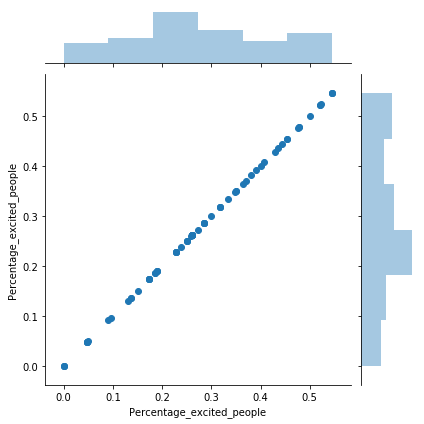

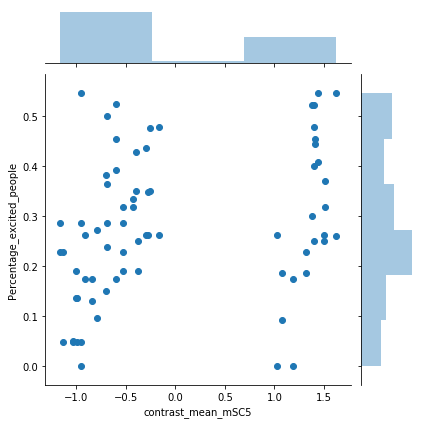

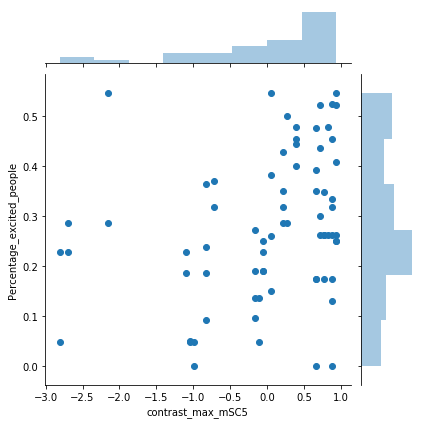

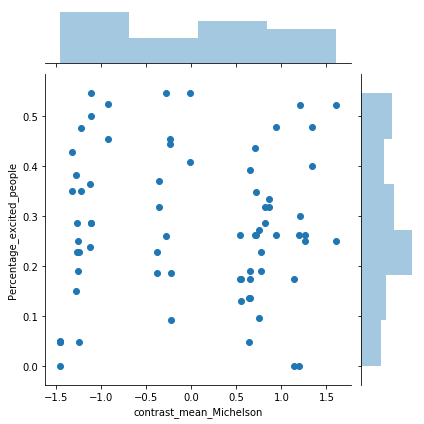

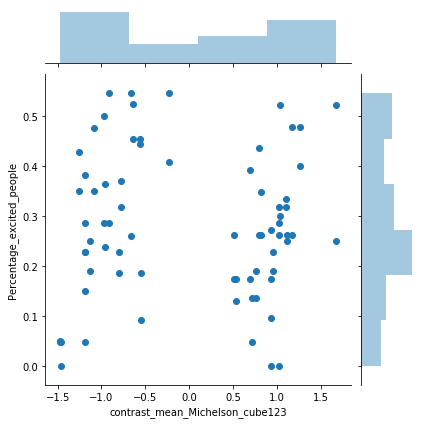

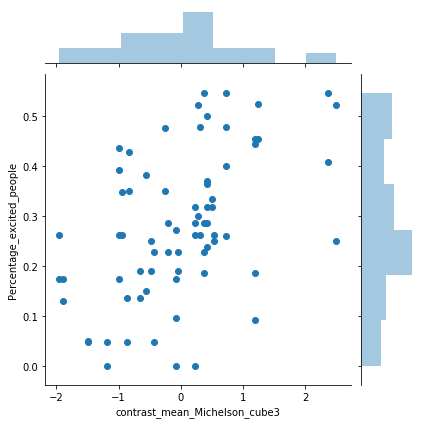

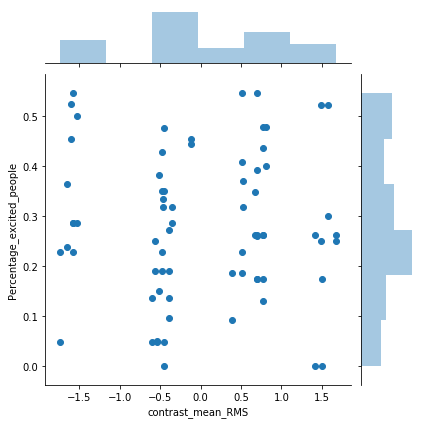

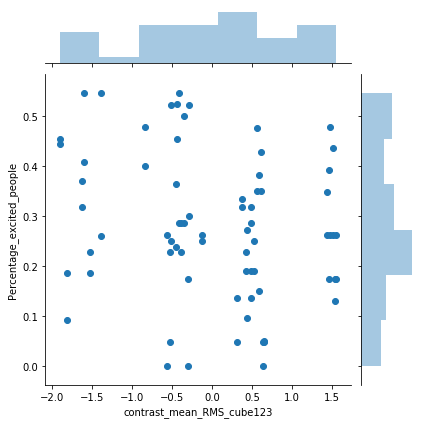

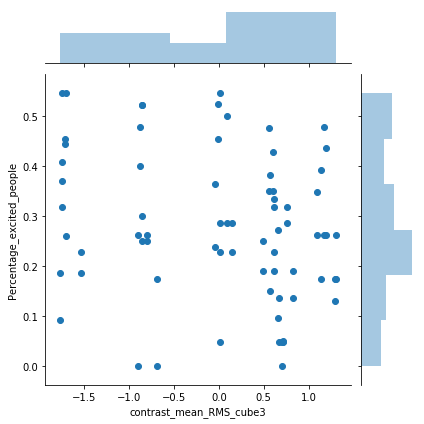

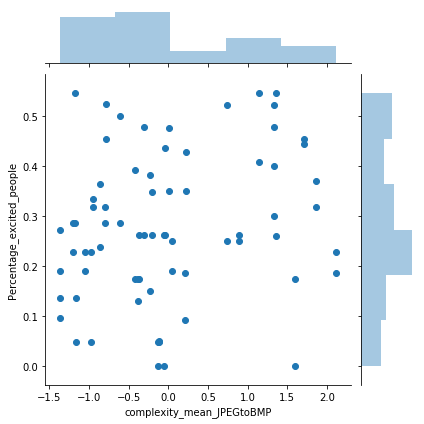

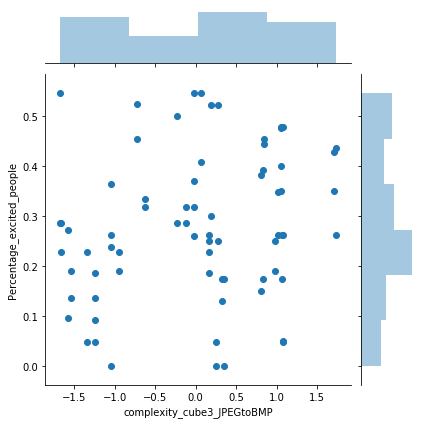

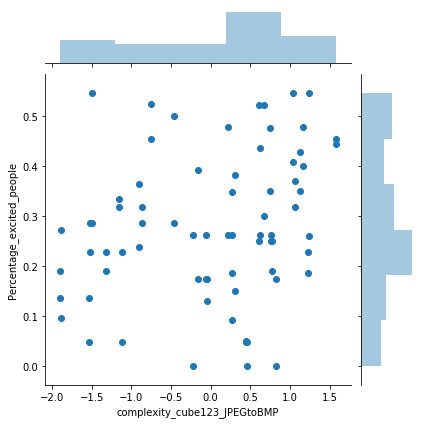

In [40]:
numeric_data = data_corr.drop( [ 'Country_Greece', 'Country_Switzerland', 'Pattern_P1EL', 'Pattern_P2EL',
       'Pattern_P3EL', 'Pattern_P4EL', 'Pattern_P5EL', 'Pattern_P6EL',
       'Context_social', 'Context_work', 'SkyType_clearhigh',
       'SkyType_clearlow', 'SkyType_overcast'], axis = 1)
for feature in numeric_data.columns:
    sns.jointplot( numeric_data[feature], numeric_data['Percentage_excited_people'], kind ="scatter")

We can also demonstrate the linear regression line estimate for each feature.

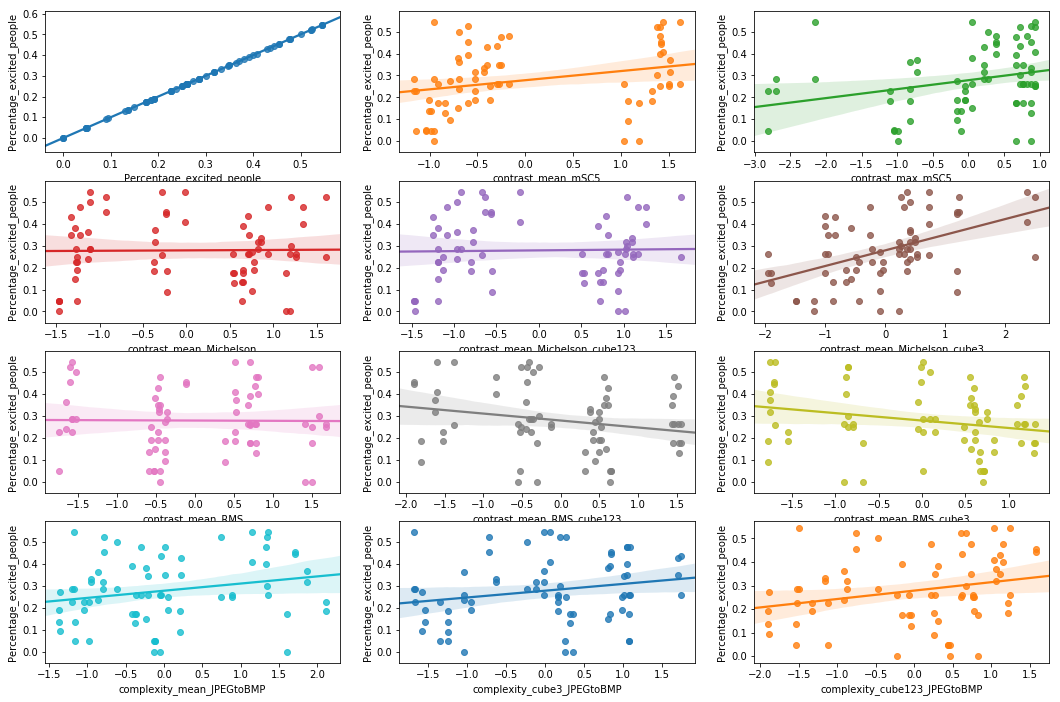

In [41]:
fig, ax = plt.subplots(round(len(numeric_data.columns) / 3), 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
        sns.regplot(x=numeric_data.columns[i],y='Percentage_excited_people', data=numeric_data, ax=ax)

## Exploring different ways for building the model

Having done that, we can start trying differents methods for obtaining predictions about the excitation of a person who do the experiment.

In [42]:
#Grid Search vizualization method
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, log_scale = False):
    """Call this method for plot a visualization of the scores of a grid search on two parameters. 
    log_scale parameter for plot in logaritmic scale
    """
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    fig, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        if log_scale:
            ax.semilogx(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))
        else:
            ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    
    return fig

## Modeling with the initial features

We first split the data into a training and a test sets. We will compare our models quality in terms of the mean absolut error (MAE) in the test set.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=0)

Now we are going to use some of the best regression methods and compare the best results obtained with them.
For doing that, we have used the sklearn library throughout the entire notebook; we have computed a grid search (with the GridSearchCV method of the mentioned librery) throught a pipeline in order to find the bes hyperparameters (and so the best model) for each method. The GridSearchCV method apply by default the Cross Validation (with 5 folders). 

So the idea is to get the best model obtained in the grid search (given the train data set) for each regressor and them compare between them with looking the test error (MAE). You can see all the best hyperparameters for each method and their errors following the next cells. The errors comparision is at the end of this notebook (we plot them in a bar char plot).

### Ridge regression 

In [44]:
#Using pipelines to make things cleaner
estimators = [('poly', PolynomialFeatures()), ('rig_reg', Ridge(solver="lsqr"))]
pipe = Pipeline(estimators)

In [45]:
lambdas = np.concatenate((np.array([0]), np.logspace(-6, 1, 50)), axis=0)
degrees = np.array([1, 2, 3, 4])

param_grid = dict(poly__degree = degrees,
                  rig_reg__alpha = lambdas)
grid_ridge = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

For rerunning the grid search again, uncomment the following lines (we have used the joblib library in order to save our searchs and not spend time rerunning them).

In [46]:
#grid_ridge.fit(X_train, y_train)
#joblib.dump(grid_ridge, MODELS_FOLDER + 'grid_ridge.pkl')

In [47]:
grid_ridge = joblib.load(MODELS_FOLDER + 'grid_ridge.pkl')

In [48]:
print("Best parameters set found on development set: \n", grid_ridge.best_params_)

Best parameters set found on development set: 
 {'poly__degree': 1, 'rig_reg__alpha': 10.0}


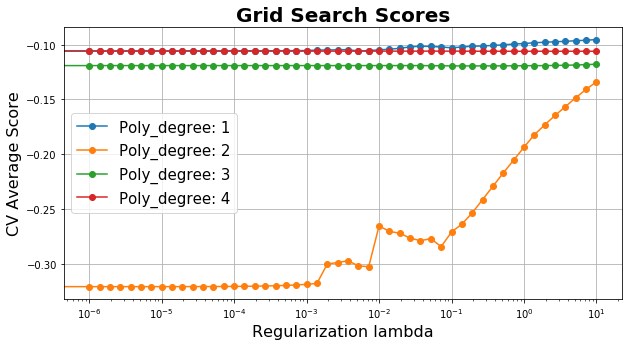

In [49]:
# Calling Method 
grid_ridge_plot = plot_grid_search(grid_ridge.cv_results_, lambdas, degrees, 'Regularization lambda', 'Poly_degree', log_scale=True)
grid_ridge_plot.set_size_inches(10,5)
grid_ridge_plot.savefig(VIS_FOLDER + 'g_ridge_lambda_degree.png', bbox_inches='tight')

In [50]:
grid_ridge.best_score_

-0.09545901537642823

In [51]:
t_error = sum(abs(grid_ridge.predict(X_test)-y_test))/len(y_test)
test_errors_initial = []
test_errors_initial = test_errors_initial + [t_error]
print("Test error: ", t_error)

Test error:  0.06396474623067165


## Lasso regression

In [52]:
from sklearn.linear_model import Lasso

estimators = [('poly', PolynomialFeatures()), ('lass_reg', Lasso())]
pipe_lasso = Pipeline(estimators) 

#lambdas = [0.000001,0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
lambdas = np.concatenate((np.array([0]), np.logspace(-9, 1, 22)), axis=0)
degrees = np.array([1, 2, 3, 4])

param_grid = dict(poly__degree = degrees,
                  lass_reg__alpha = lambdas)
g_search_lass = GridSearchCV(pipe_lasso, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

In [53]:
#g_search_lass.fit(X_train, y_train)
#joblib.dump(g_search_lass, MODELS_FOLDER + 'grid_lasso.pkl')

In [54]:
g_search_lass = joblib.load(MODELS_FOLDER + 'grid_lasso.pkl')

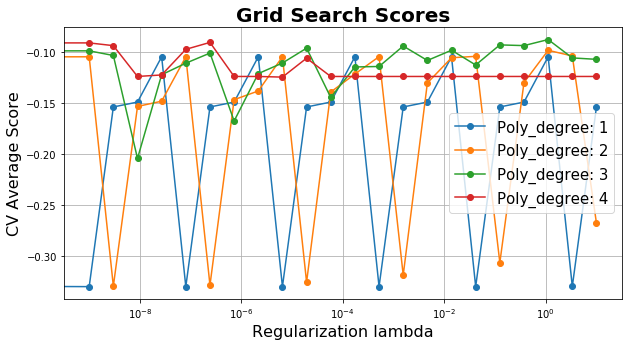

In [55]:
# Calling Visualization Method 
grid_lasso_plot = plot_grid_search(g_search_lass.cv_results_, lambdas, degrees, 'Regularization lambda', 'Poly_degree', log_scale=True)
grid_lasso_plot.set_size_inches(10,5)
grid_lasso_plot.savefig(VIS_FOLDER + 'g_lasso_lambda_degree.png', bbox_inches='tight')

In [56]:
print("Best parameters set found on development set:")
print()
print(g_search_lass.best_params_)

Best parameters set found on development set:

{'lass_reg__alpha': 0.01389495494373136, 'poly__degree': 3}


In [57]:
g_search_lass.best_score_

-0.08730994190005008

In [58]:
t_error = sum(abs(g_search_lass.predict(X_test)-y_test))/len(y_test)
test_errors_initial = test_errors_initial + [t_error]
print("Test error: ", t_error)

Test error:  0.061160554931663745


## Random Forest Regression

In [59]:
from sklearn.ensemble import RandomForestRegressor

#estimators = [('poly', PolynomialFeatures()), ('lass_reg', Lasso())]
estimators = [('rf_reg', RandomForestRegressor())]
pipe_rf = Pipeline(estimators)

n_estim = np.arange(1,200,10)
max_depths = np.arange(1,25)

param_grid = dict(rf_reg__n_estimators = n_estim,
                  rf_reg__max_depth = max_depths)
g_search_rf = GridSearchCV(pipe_rf, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

In [60]:
#g_search_rf.fit(X_train, y_train)
#joblib.dump(g_search_rf, MODELS_FOLDER + 'grid_rf.pkl')

g_search_rf = joblib.load(MODELS_FOLDER + 'grid_rf.pkl')

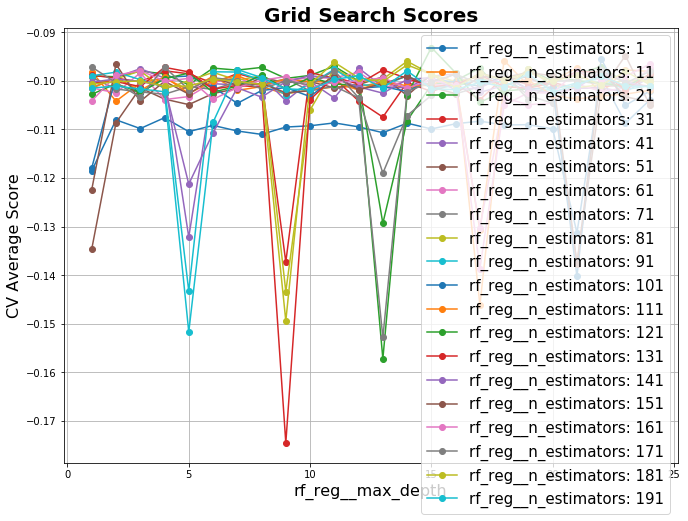

In [61]:
# Calling Visualization Method 
grid_rf_plot = plot_grid_search(g_search_rf.cv_results_, max_depths, n_estim, 'rf_reg__max_depth', 'rf_reg__n_estimators')
grid_rf_plot.set_size_inches(11,8)
grid_rf_plot.savefig(VIS_FOLDER + 'g_rf_depth_estimators.png', bbox_inches='tight')

In [62]:
print("Best parameters set found on development set: \n", g_search_rf.best_params_)

Best parameters set found on development set: 
 {'rf_reg__max_depth': 16, 'rf_reg__n_estimators': 21}


In [63]:
g_search_rf.best_score_

-0.09315047435529801

Best parameters before run a grid search with nestim=range(1,100) and max_depths=range(1,100): {'rf_reg__max_depth': 19, 'rf_reg__n_estimators': 10} with score: -0.08968294326799285.

![title](visualizations/grid_search_random_forest_100_100.png)

What's about the most important features for the best model obtained with Random Forest?

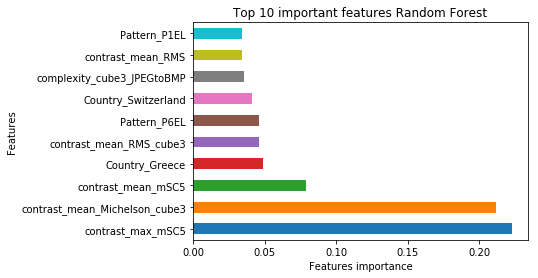

In [64]:
#g_search_rf.best_estimator_.steps[0][1] to acces to the best regressor troughout the pipeline
feat_importances = pd.Series(g_search_rf.best_estimator_.steps[0][1].feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 important features Random Forest')
plt.xlabel('Features importance')
plt.ylabel('Features')
plt.savefig(VIS_FOLDER + 'features_importance_rf.png', bbox_inches='tight')

Above you see the importance of the ten most important for this specific model.

In [65]:
t_error = sum(abs(g_search_rf.predict(X_test)-y_test))/len(y_test)
test_errors_initial = test_errors_initial + [t_error]
print("Test error: ", t_error)

Test error:  0.08832569674529647


## XGBOOST regression

In [66]:
import xgboost as xgb

In [67]:
estimators = [('xgb_reg', xgb.XGBRegressor())]
pipe_xgb = Pipeline(estimators)

n_estim = np.arange(1,144, 3)
max_depths = np.arange(1,11)

param_grid = dict(xgb_reg__n_estimators = n_estim,
                  xgb_reg__max_depth = max_depths)
g_search_xgb = GridSearchCV(pipe_xgb, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

In [68]:
#g_search_xgb.fit(X_train, y_train)
#joblib.dump(g_search_xgb, MODELS_FOLDER + 'grid_xgb.pkl')

g_search_xgb = joblib.load(MODELS_FOLDER + 'grid_xgb.pkl')

In [69]:
print("Best parameters set found on development set: \n")
print(g_search_xgb.best_params_)
print("\n With the best score:\n")
print(g_search_xgb.best_score_)

Best parameters set found on development set: 

{'xgb_reg__max_depth': 1, 'xgb_reg__n_estimators': 85}

 With the best score:

-0.09727993680014257


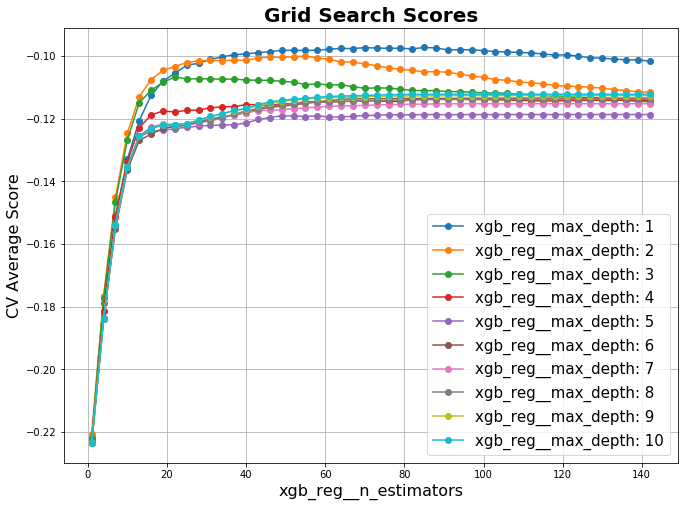

In [70]:
# Calling Visualization Method 
grid_xgb_plot = plot_grid_search(g_search_xgb.cv_results_, n_estim, max_depths, 'xgb_reg__n_estimators', 'xgb_reg__max_depth')
grid_xgb_plot.set_size_inches(11,8)
grid_xgb_plot.savefig(VIS_FOLDER + 'g_xgb_depth_estimators.png', bbox_inches='tight')

What's about the most important features for the best model obtained with the xgboost regressor?

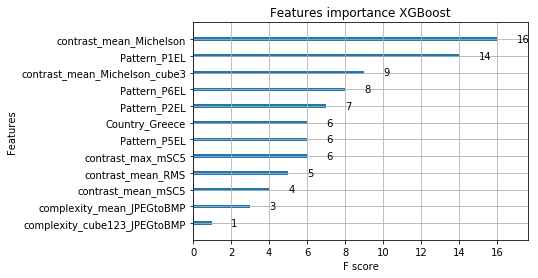

In [71]:
from xgboost import plot_importance
plot_importance(g_search_xgb.best_estimator_.steps[0][1])
plt.title('Features importance XGBoost')
plt.savefig(VIS_FOLDER + 'feature_importance_xgb.png', bbox_inches='tight')

In [72]:
t_error = sum(abs(g_search_xgb.predict(X_test)-y_test))/len(y_test)
test_errors_initial = test_errors_initial + [t_error]
print("Test error: ", t_error)

Test error:  0.07532656872096566


# Performing PCA on images

## Compressing images

First we try to read an image, see its dimension and load it into an array.

Recall: To install imageio use the command "conda install -c conda-forge imageio"

In [73]:
path = IMAGES_PATH + 'p1_social_clearhigh_sg_largewin_simu/cube_persp.bmp'
image = imageio.imread(path)

print(image.shape)

(1368, 4104, 3)


In [74]:
image = np.asarray(image)

In [75]:
image.shape

(1368, 4104, 3)

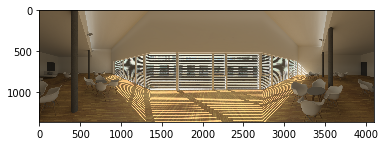

In [76]:
plt.imshow(image)

Flattening the image into a 1-dimension array:

In [77]:
image = image.flatten()
image.shape

(16842816,)

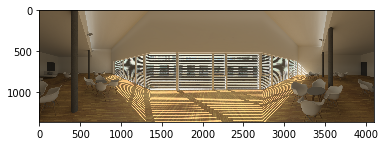

In [78]:
# this way we can reproduce the image
image = image.reshape([1368, 4104, 3])
plt.imshow(image)

#### Trying to reduce the size of this image as example

As the images have a very high resolution and they are in color (not gray-scale); we have found in the next section that it is impossible to deal with them (to compute the PCA with such amount of data). So we firt need to reduce the size of them. Let's try with one of them:

You also need to instal scikit-image: conda install -c anaconda scikit-image 

The 3 dimensions are used for the color; so if we take only one of them, we take the intensity of one of the colors (rgb); which is equivalent to take the image as greyscale (uncomment below for seeing): 

In [79]:
#plt.imshow(image[:,:,0])

In [80]:
image = image[:,:,0]

In [81]:
image_rescaled = rescale(image, 1.0 / 6.0, anti_aliasing=False)  #/4 keep quite image quality 
image_resized = resize(image, (image.shape[0] / 6, image.shape[1] / 6), #/4 keep quite image quality 
                       anti_aliasing=True)
image_downscaled = downscale_local_mean(image, (6,12)) #/(4,3) keep quite image quality 
                                                        #(4,3,1) if we have not removed the 3 dimensions

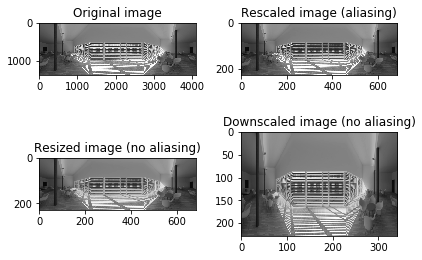

In [82]:
fig, axes = plt.subplots(nrows=2, ncols=2)

ax = axes.ravel()

ax[0].imshow(image, cmap='gray')#, aspect='auto')   #aspect='auto' for improving the 4 visualizations quality
ax[0].set_title("Original image")

ax[1].imshow(image_rescaled, cmap='gray')#, aspect='auto')
ax[1].set_title("Rescaled image (aliasing)")

ax[2].imshow(image_resized, cmap='gray')#, aspect='auto')
ax[2].set_title("Resized image (no aliasing)")

ax[3].imshow(image_downscaled, cmap='gray')#, aspect='auto')
ax[3].set_title("Downscaled image (no aliasing)")

plt.tight_layout()
plt.savefig(VIS_FOLDER + 'resized_and_downscaled.png', bbox_inches='tight')
plt.show()

#### Visualization of the original and the finally used downscaled one (for the report)

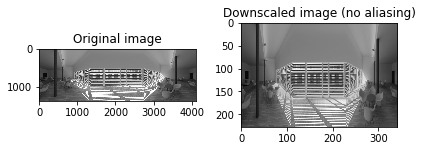

In [83]:
fig, axes = plt.subplots(nrows=1, ncols=2)

ax = axes.ravel()

ax[0].imshow(image, cmap='gray')#, aspect='auto')   #aspect='auto' for improving the 4 visualizations quality
ax[0].set_title("Original image")

ax[1].imshow(image_downscaled, cmap='gray')#, aspect='auto')
ax[1].set_title("Downscaled image (no aliasing)")

plt.tight_layout()
plt.savefig(VIS_FOLDER + 'downscaled.png', bbox_inches='tight')
plt.show()

Which of the image compressions is the best to do? -> They do the same (except for the alisign) but given different arguments.

In [84]:
print(image.shape)
print(image_rescaled.shape)
print(image_resized.shape)
print(image_downscaled.shape)

(1368, 4104)
(228, 684)
(228, 684)
(228, 342)


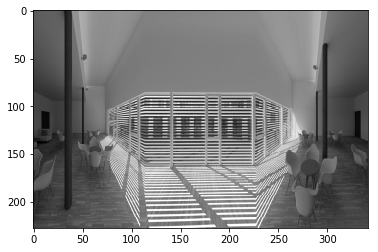

In [85]:
plt.imshow(image_downscaled, cmap='gray', aspect='auto')

Let's try with the last one process, image_downscaled, but now for every image (we have chosen this kind of reshape in order to not lose too much quality about the light patterns):

#### Getting the list of pixels of every downscaled image:

In [86]:
# read all the images
shadows = ['p1', 'p2', 'p3','p4', 'p5', 'p6']
enviro = ['social', 'work']
sun = ['clearhigh', 'clearlow', 'overcast']
image_name = "cube_persp.bmp"

pixels = []
for sh in shadows:
    for e in enviro:
        for s in sun:
            folder_name = sh+ "_"+ e+ "_"+ s+ "_"+ "sg_largewin_simu/"
            path = IMAGES_PATH + folder_name + image_name 
            im = imageio.imread(path)
            #NEW
            im = im[:,:,0]
            im = downscale_local_mean(im, (6,12))
            
            im = np.asarray(im)
            im = im.flatten()
            pixels.append([sh.upper()+"EL", e, s, im])
            

In [87]:
pixels_df = pd.DataFrame(pixels)

In [88]:
pixels_df.columns = ['Pattern', 'Context', 'SkyType', 'img_array']

In [ ]:
pixels_df.sample(4)

,Pattern,Context,SkyType,img_array
20,P4EL,social,overcast,"[94.0, 94.41666666666667, 95.0, 95.0, 95.0, 95..."
4,P1EL,work,clearlow,"[111.0, 111.52777777777779, 112.01388888888887..."
33,P6EL,work,clearhigh,"[107.125, 107.45833333333333, 108.0, 108.0, 10..."
23,P4EL,work,overcast,"[97.45833333333333, 98.0, 98.0, 98.05555555555..."


In [ ]:
fdata[['Country', 'Pattern', 'Context', 'SkyType', 'Percentage_excited_people']].sample(3)

,Country,Pattern,Context,SkyType,Percentage_excited_people
57,Switzerland,P5EL,work,clearlow,0.400000
23,Switzerland,P2EL,work,overcast,0.190476
53,Switzerland,P5EL,social,overcast,0.285714


In [ ]:
percent_excited = fdata[['Country', 'Pattern', 'Context', 'SkyType', 'Percentage_excited_people']]

In [ ]:
pixels_excited_df = percent_excited.set_index(['Pattern', 'Context', 'SkyType']).join(pixels_df.set_index(['Pattern', 'Context', 'SkyType']))

In [ ]:
pixels_excited_df.head()

Country  Percentage_excited_people  \
Pattern Context SkyType                                             
P1EL    social  clearhigh       Greece                   0.047619   
                clearhigh  Switzerland                   0.000000   
                clearlow        Greece                   0.185185   
                clearlow   Switzerland                   0.090909   
                overcast        Greece                   0.227273   

                                                                   img_array  
Pattern Context SkyType                                                       
P1EL    social  clearhigh  [103.0, 103.125, 103.84722222222221, 103.95833...  
                clearhigh  [103.0, 103.125, 103.84722222222221, 103.95833...  
                clearlow   [110.0, 110.0, 110.54166666666667, 111.0, 111....  
                clearlow   [110.0, 110.0, 110.54166666666667, 111.0, 111....  
                overcast   [94.0, 94.0, 94.75, 95.0, 95.0, 95.0, 95.41666...

We save the dataframe with the compressed images data (in order to use it in the notebook where we work with every feeling):

In [ ]:
pixels_excited_df.to_parquet(DATA_FOLDER + "pixels_compressed.parquet") #The images are the same for Greece and Switzerland

# PCA - Principal Component Anlysis with the image vectors: 

The Principal Component Analysis (PCA) does an unsupervised dimensionality reduction, while the ridge regression does the prediction.
We use a GridSearchCV to set the dimensionality of the PCA.

### Preparing the data
First of all we prepare the data (extracting the vectors from the `pixels_excited_df` data frame and obtaining a matrix with the images pixels and a vector with the outputs, the percentages):

In [ ]:
pixels_greece = pixels_excited_df[pixels_excited_df["Country"]=="Greece"]
pixels_switz = pixels_excited_df[pixels_excited_df["Country"]=="Switzerland"]

In [ ]:
x_matrix_temp_greece = [pixels_array.tolist() for pixels_array in pixels_greece["img_array"].values]
x_matrix_temp_switz = [pixels_array.tolist() for pixels_array in pixels_switz["img_array"].values]

In [ ]:
print(len(x_matrix_temp_greece))
print(len(x_matrix_temp_greece[0]))

36
77976


### Standardizing and splitting
It is important to standardize the pixels vector in order to obtain good results with the PCA:

In [ ]:
### Preparing Matrices

## Greece
X_digits_greece = x_matrix_temp_greece
y_digits_greece = pixels_greece["Percentage_excited_people"].values

# Standardize
X_greece = preprocessing.scale(X_digits_greece)

# Splitting of the data
phX_train_greece, phX_test_greece, y_train_greece, y_test_greece = train_test_split(X_greece, y_digits_greece, test_size=0.2, random_state=0)

# Pol expansion (in our case add a constant (bias)) for all data
# pol = PolynomialFeatures(1, True, True)
# phX_train_greece = pol.fit_transform(phX_train_greece, y_train_greece)
# phX_test_greece = pol.fit_transform(phX_test_greece, y_test_greece)


## Switzerland
X_digits_switz = x_matrix_temp_switz
y_digits_switz = pixels_switz["Percentage_excited_people"].values

# Standardize
X_switz = preprocessing.scale(X_digits_switz)

# Splitting of the data
phX_train_switz, phX_test_switz, y_train_switz, y_test_switz = train_test_split(X_switz, y_digits_switz, test_size=0.2, random_state=0)

### REGRESSION GRID SEARCH: SELECTING THE BEST MODEL

First we define all the pipelines and all the parameters (for each estimator) for the grid search. Note that we are going to do the same that we did with the initial features (with the given metrics) but now with the features obtained by the PCA on the compressed images:

In [ ]:
pca = PCA()

### Preparing the pipes
pipes = []
estimators_ridge = steps = [('pca', pca), ('rig_reg', Ridge(solver="lsqr"))]
pipe_ridge = Pipeline(estimators_ridge)

estimators_lasso = steps = [('pca', pca), ('lass_reg', Lasso())]
pipe_lasso = Pipeline(estimators_lasso) 

estimators_rf = steps = [('pca', pca), ('rf_reg', RandomForestRegressor())]
pipe_rf = Pipeline(estimators_rf)

estimators_xgb = steps = [('pca', pca), ('xgb_reg', xgb.XGBRegressor())]
pipe_xgb = Pipeline(estimators_xgb)

pipes = [pipe_ridge, pipe_lasso, pipe_rf, pipe_xgb]
## Preparing the Grid Search with cross-validation; so it is splitting and we cannot put more than len(phX_train_greece) components
param_grid = []

## Parameters of pipelines can be set using ‘__’ separated parameter names:

PCA_n_comp = np.arange(4, 22, 2) # must be between 0 and min(n_samples, n_features)=n_samples=phX_train_greece

# Ridge
lambdas = np.logspace(-6, 0, 20)

param_grid_ridge = dict(pca__n_components = PCA_n_comp, rig_reg__alpha = lambdas)

# Lasso
lambdas = np.logspace(-6, 0, 20)
#lambdas = np.concatenate((np.array([0]), np.logspace(-9, 4, 22)), axis=0)

param_grid_lasso = dict(pca__n_components = PCA_n_comp, lass_reg__alpha = lambdas)

# XGB
n_estim = np.arange(1,50, 5)
max_depths = np.arange(1,15, 4)

param_grid_xgb = dict(xgb_reg__n_estimators = n_estim, xgb_reg__max_depth = max_depths, pca__n_components = PCA_n_comp)

# RF
n_estim = np.arange(1, 50, 5)
max_depths = np.arange(1,15, 4)

param_grid_rf = dict(rf_reg__n_estimators = n_estim, rf_reg__max_depth = max_depths, pca__n_components = PCA_n_comp)

## Param grid for every model

param_grid = [param_grid_ridge, param_grid_lasso, param_grid_rf, param_grid_xgb]

In [ ]:
print(len(phX_train_greece))

28


#### GREECE

In [ ]:
search_greece = []
#Running GRID SEARCH WITH ALL THE ESTIMATORS
h=0
while(h<len(pipes)):
    ## Instantiation of Grid Search
    #Grid search will take by default the estimator's default scorer, i.e. the least squares from ridge regression estimator

    search_greece = search_greece + [(GridSearchCV(pipes[h], param_grid[h], iid=False, cv=5, return_train_score=True, scoring = 'neg_mean_absolute_error'))] #We can change it to false if we are not interested in this score
    #Note: iid-> the loss minimized is the total loss per sample, and not the mean loss across the folds! Put it a false if we use

    ## Modeling
    search_greece[h].fit(phX_train_greece, y_train_greece)
    h=h+1

In [ ]:
joblib.dump(search_greece, MODELS_FOLDER + 'final_grid_greece.pkl')
#search_greece = joblib.load(MODELS_FOLDER + 'final_grid_greece.pkl')

Getting best result for every model-estimator:

In [ ]:
ypred_test_greece = np.zeros((len(search_greece), len(y_test_greece)))
dif_rest_greece = np.zeros(len(search_greece))
mse_rest_greece = np.zeros(len(search_greece))

h=0
while(h<len(search_greece)):
    ypred_test_greece[h] = search_greece[h].predict(phX_test_greece)
    dif_rest_greece[h] = sum(abs(ypred_test_greece[h]-y_test_greece))/len(y_test_greece)
    mse_rest_greece[h] = sum(abs(ypred_test_greece[h]-y_test_greece)**2)/len(y_test_greece)

    print(search_greece[h].best_params_)
    print(dif_rest_greece[h])
    h=h+1

#### SWITZERLAND

Same grid search for modeling the Switzerland labels:

In [ ]:
search_switz = []
#Running GRID SEARCH WITH ALL THE ESTIMATORS
h=0
while(h<len(pipes)):
    #Grid search will take by default the estimator's default scorer
    search_switz.append(GridSearchCV(pipes[h], param_grid[h], iid=False, cv=5, return_train_score=True, scoring = 'neg_mean_absolute_error')) #We can change it to false if we are not interested in this score
    
    ## Modeling
    search_switz[h].fit(phX_train_switz, y_train_switz)
    
    h=h+1

In [ ]:
joblib.dump(search_switz, MODELS_FOLDER + 'final_grid_switz.pkl')
#search_switz = joblib.load(MODELS_FOLDER + 'final_grid_switz.pkl')

Getting best result for every model-estimator

In [ ]:
ypred_test_switz = np.zeros((len(search_switz), len(y_test_switz)))
dif_rest_switz = np.zeros(len(search_switz))
mse_rest_switz = np.zeros(len(search_switz))

h=0
while(h<len(search_switz)):
    ypred_test_switz[h] = search_switz[h].predict(phX_test_switz)
    dif_rest_switz[h] = sum(abs(ypred_test_switz[h]-y_test_switz))/len(y_test_switz)
    mse_rest_switz[h] = sum(abs(ypred_test_switz[h]-y_test_switz)**2)/len(y_test_switz)
    
    print("Best parameter (CV score=%0.3f):" % search_switz[h].best_score_)
    print(search_switz[h].best_params_)
    print(dif_rest_switz[h])
    print(mse_rest_switz[h])
    
    h=h+1

#### Plot of the expected outputs and the predictions
(If the prediction would have been totally precise, the points would be in the diagonal)

In [ ]:
plt.title("Y pred test and Y test")
plt.xlabel("Y test")
plt.ylabel("Y test predicted")
plt.plot(y_test_greece, ypred_test_greece[0], 'ro')

#### Plot of the PCA spectrum
(Just the PCA without an estimator)

In [ ]:
pca.fit(X_greece)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Ridge score (val)')
ax1.set_xlabel('n_components')

plt.tight_layout()
plt.show()

In [ ]:
grid_ridge_plot = plot_grid_search(search.cv_results_, lambdas, PCA_n_comp, 'rig_reg__alpha', 'pca__n_components')
grid_ridge_plot.savefig(VIS_FOLDER + 'g_PCA_ridge.png', bbox_inches='tight')

### PCA interpretation visualizations

See the report for read the interpretation:

In [ ]:
components_pixels = search.best_estimator_.named_steps['pca'].components_


for eigen_image in components_pixels:
    # reshape
    image = np.array(eigen_image).reshape(228, 342)
    
    # plot
    plt.figure(figsize = (6,6))
    plt.imshow(image, cmap='gray')

In [ ]:
components_pixels = search.best_estimator_.named_steps['pca'].components_
coefs = search.best_estimator_.named_steps['rig_reg'].coef_

In [ ]:
importance_component = pd.DataFrame([coefs,components_pixels]).transpose()
importance_component.columns = ['coefs','components']
importance_component['coefs'] = importance_component['coefs'].astype('float64')

In [ ]:

 
sum_wigths = importance_component['coefs'].abs().sum()

importance_component['relative_importance'] = importance_component['coefs']/sum_wigths


top_n_positive = importance_component.nlargest(4, 'coefs')

top_n_negative = importance_component.nsmallest(4,'coefs')

 

Ploting principal components and relative importance

In [ ]:
for i,row in top_n_positive.iterrows():
    relative_importance = row['relative_importance']
    image = row['components']
    # reshape
    image = image.reshape(228, 342)
    
    # plot
    
    plt.figure(figsize = (6,6))
    plt.title('Relative_importance = '+ str('%.5f'%relative_importance))
    plt.imshow(image, cmap='gray')
    

# Comparing image PCA results with the initial features results

We finally compare the errors obtained with the PCA images features and the initial features (the metrics given by the lab): 

In [ ]:
#test_errors_initial = [0.06817515506807749,0.08035263195919472,0.08832569674529647,0.07532656872096566]
test_errors_PCA = [0.0517987, 0.0709366,0.083401, 0.093482]
#test_errors_PCA = dif_rest_greece
index = ['Initial features test error', 'Image PCA test error']
columns = ['Ridge', 'Lasso', 'Random Forest', 'XGBoost']
values=[test_errors_initial, test_errors_PCA]
#With this data frame we will obtain the bar chart automatically.
df_plot = pd.DataFrame(values, index=index)
df_plot.columns=columns
df_plot 

df_plot.T.plot.bar()#figsize=(20, 10))
plt.title("Features comparion")
plt.savefig(VIS_FOLDER + 'comparing_PCA_vs_ifeatures.png', bbox_inches='tight')
plt.show()